In [1]:
import numpy as np
import sys
sys.path.append('../../')
sys.path.append('../../pyfos/')
from pyfos.models.feedforward import build_feedforward
from pyfos.models.var_feedforward import build_var_feedforward
from pyfos.generic.optimizer import gd_optimizer
from pyfos.generic.regularizers import gaus_prior
from functools import partial 
from pyfos.tc.simple import  simple_tc
from pyfos.tc.cv import  cv_tc
from pyfos.hyperoptimizers.random_search import random_optimize
from pyfos.hyperoptimizers.greed_optimize import greed_optimize
import theano
%matplotlib inline
import matplotlib.pylab as plt
import random
import cPickle

In [2]:
with open('./results_var_mad.pckl', 'rb') as inp:
    mad = cPickle.load(inp)
with open('./results_var_rand.pckl', 'rb') as inp:
    rand = cPickle.load(inp)    
with open('./results_var_greed.pckl', 'rb') as inp:
    greed = cPickle.load(inp)
with open('./results_var_hoag.pckl', 'rb') as inp:
    hoag = cPickle.load(inp)
matrix = np.load('../../../data/matrix.npy')
X, Y = np.load('../../../data/linearx.npy'), np.load('../../../data/lineary.npy')

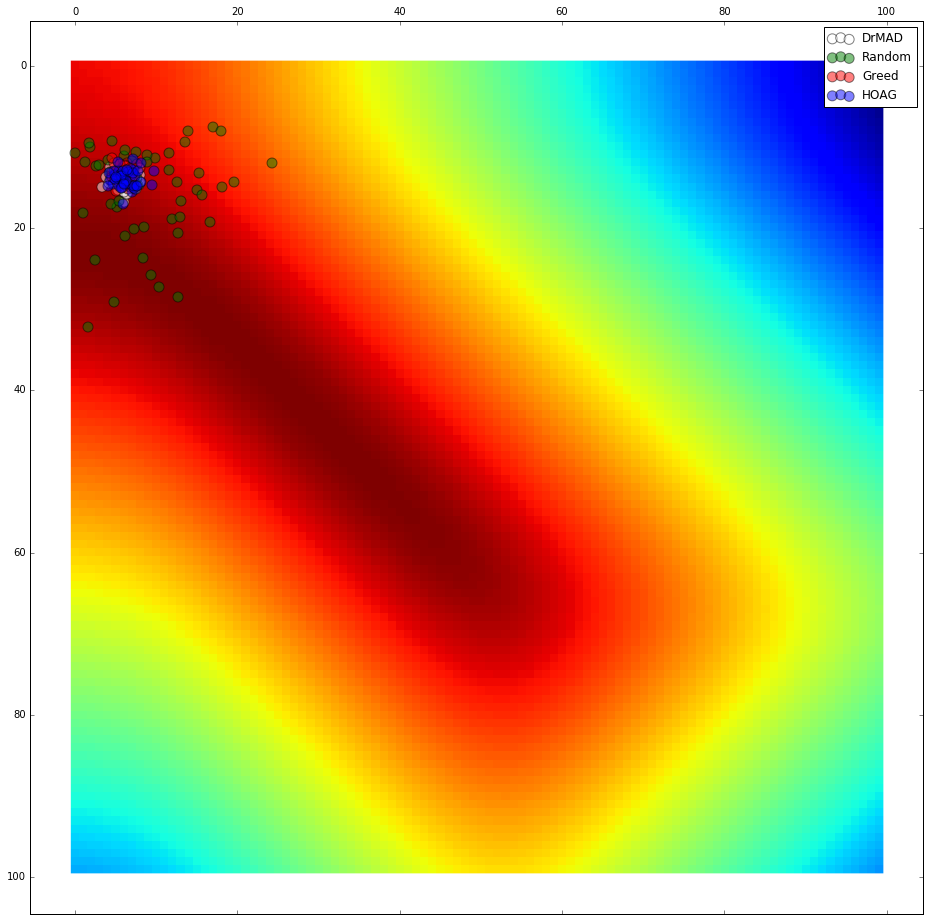

In [6]:
plt.matshow(matrix.T)
for dataset, label, c in [(mad, 'DrMAD', 'w'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                        ]:
    first = True
    for i in dataset:
        first_value = i.history[0][0][0]
        i = i.best_values[0]
        
        first_value = np.log10(np.exp(2*first_value))*10
        i = np.log10(np.exp(2*i))*10
        
        if first:
            plt.scatter(i[0] + np.random.randn(1)*1,i[1]+ np.random.randn(1)*1, c=c, label=label, alpha=0.5, s=100)
            first = False
        else:
            plt.scatter(i[0]+ np.random.randn(1)*1,i[1]+ np.random.randn(1)*1, c=c, alpha=0.5, s=100)
        #print [first_value[0], i[0]],[first_value[1], i[1]]
        #plt.plot([first_value[0], i[0]],[first_value[1], i[1]])
        
plt.legend(loc='best')
plt.rcParams['figure.figsize'] = (20,20)
#plt.scatter(2713%100 ,2713/100, s=1000)


DrMAD
-104.198314671
Random
-104.852149285
Greed
-104.205057019
HOAG
-104.202176125


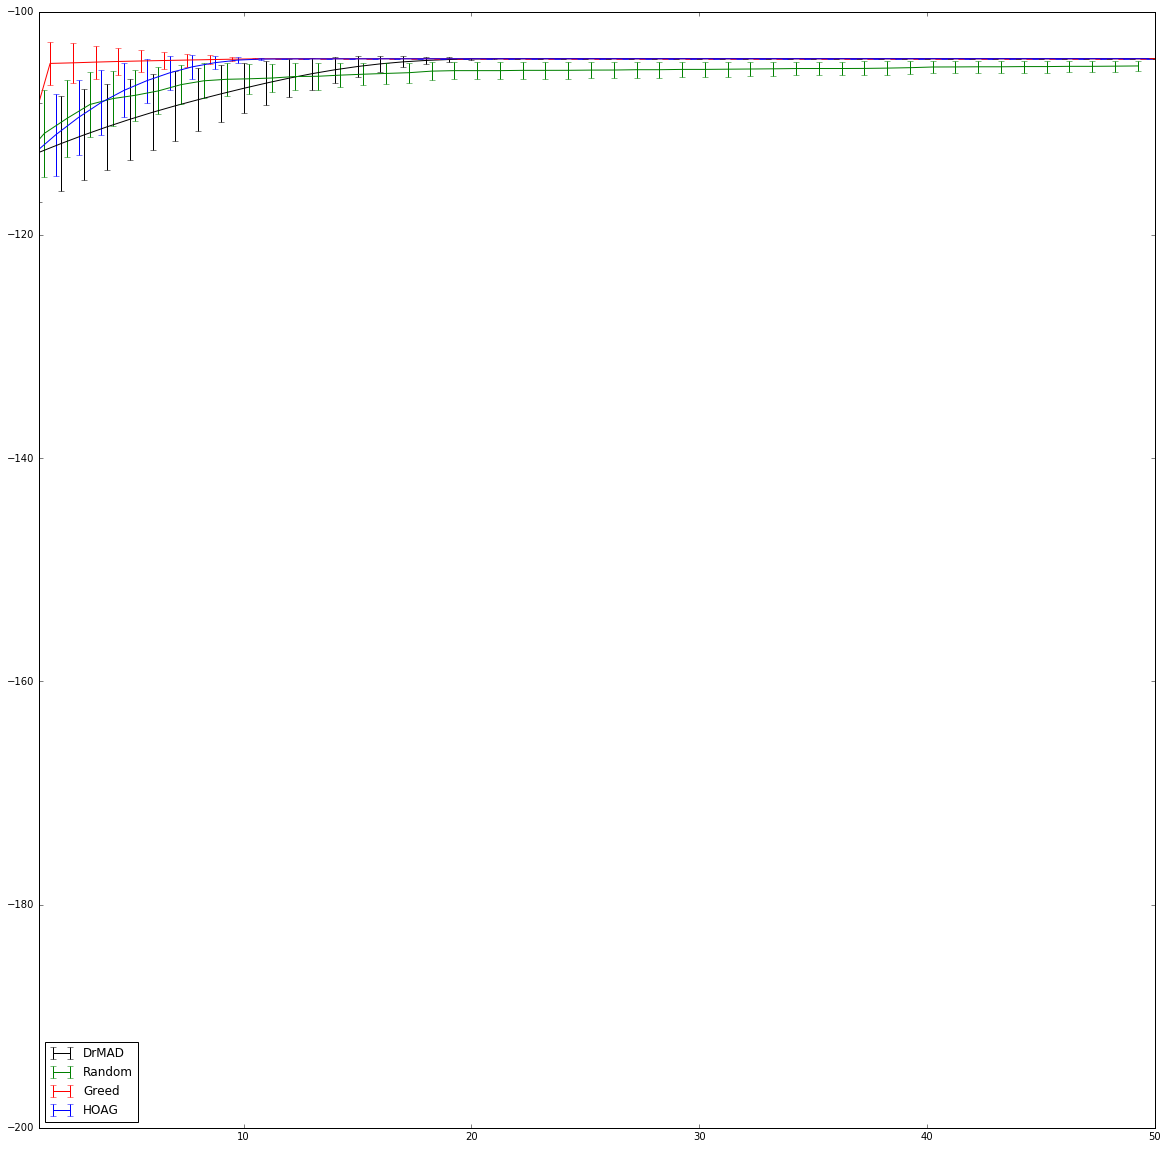

In [8]:
id = -1
for dataset, label, c in [
                        (mad, 'DrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    
    line = []
    for b in dataset:
      
        history = []
        for i in xrange(0, len(b.history)):
        
            best_value = max([h[1] for h in b.history[:i+1]])
            #if i==49 and label=='Greed':
            #    print [h[1] for h in b.history], best_value
            history.append(best_value)
            
        if not np.isnan(np.mean(history)):
            
            line.append(history)
    print label
    print np.mean(line, axis=0)[-1]
    #plt.fill_between(range(len( np.mean(line, axis=0))),  np.mean(line, axis=0)-np.std(line, axis=0), np.mean(line, axis=0)+np.std(line, axis=0), facecolor=c, alpha=0.25 )
    plt.errorbar(np.array(range(len(line[0])))+id*1.0/4, np.mean(line, axis=0), yerr=np.std(line, axis=0), c=c, lw=1, label=label)
    #plt.plot( np.mean(line, axis=0), label=label, c=c, lw=3)
plt.ylim((-200, -100))
plt.xlim((1,50))
plt.legend(loc='best')
                                                                                           

In [37]:
print greed[5].history[50]

([array([ 2.51429802,  3.7130209 ]), array(7.880633244453523e-05)], array(-108047.33033329305))


start
DrMAD
0.0114774404255 6.49072715801e-08
Random
0.0123865582701 0.00410194438321
Greed
0.011480786363 0.000285869014428
HOAG
0.0115947648918 0.000274324231782


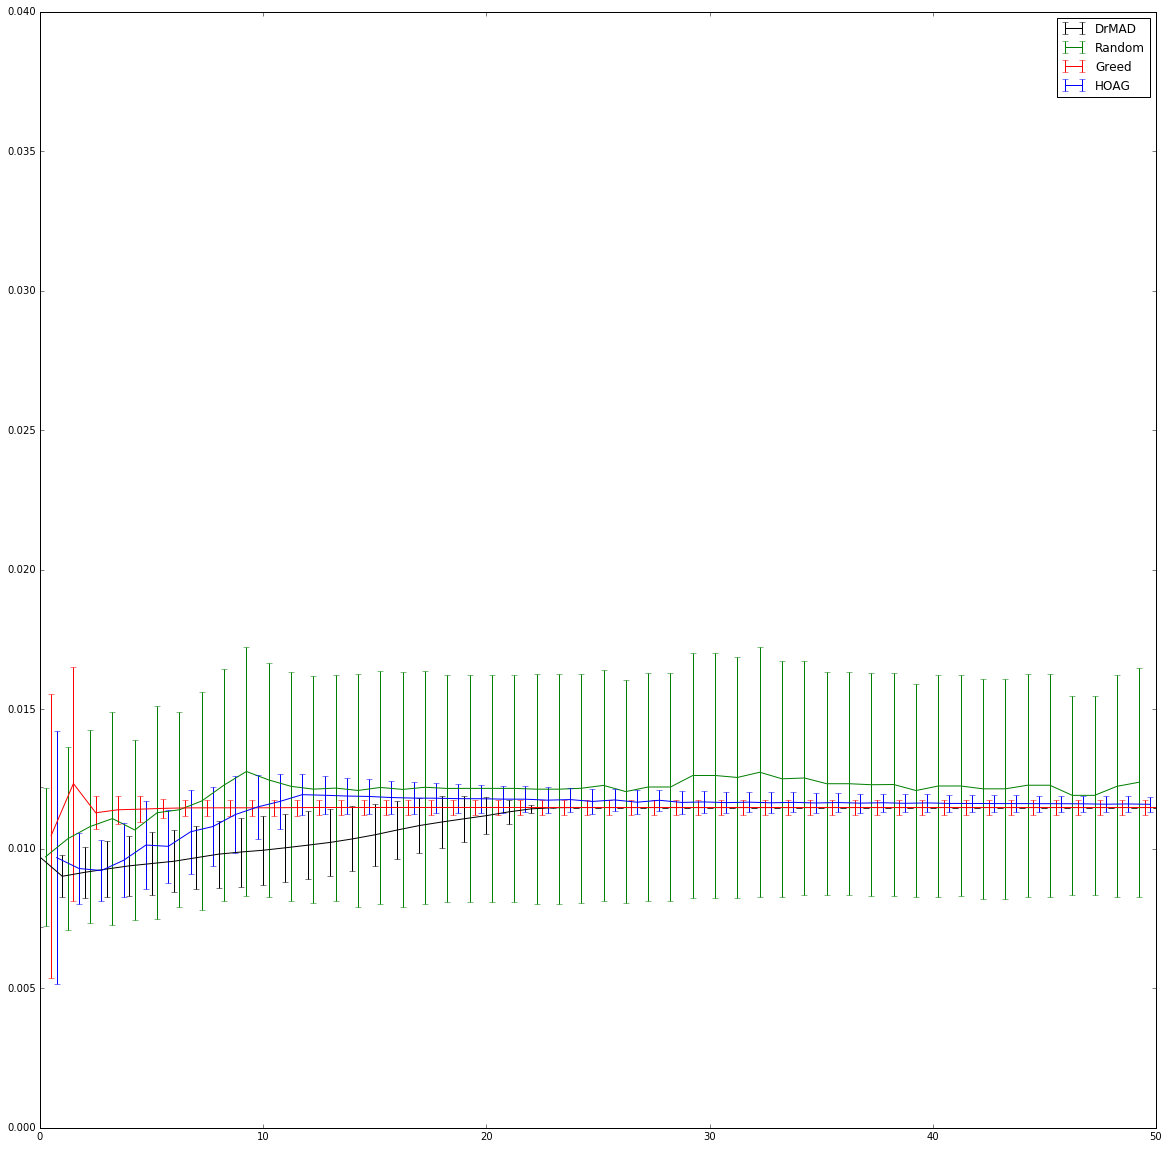

In [11]:
import theano.tensor as T
lr = theano.shared(0.01)
alphas = theano.shared(np.array([1.0, 1.0]))
optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward, structure = [2,1], nonlinearity=lambda x:x, log_alphas =alphas, bias=False)
#model_build = partial(build_var_feedforward, structure = [2,1], nonlinearity=lambda x:x, log_alphas=alphas, bias=False, param_pool_size=100)
X_train = X[:100]
Y_train = Y[:100]
X_test = X[100:]
Y_test = Y[100:]
training_procedure = simple_tc( model_build, optimizer, X_train, Y_train,  batch_size=100 )



X_t = T.matrix()
result = []

predicts = []

for m in training_procedure.models:    
    predict = m.predict_var(X_t)
    predicts.append(theano.function([X_t], predict))
print 'start'
id = -1
for dataset, label, c in [
                         (mad, 'DrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    print label
    line = []

    for b in dataset:

        history = []
        for i in xrange(len(b.history)):
            try:
                best_value = np.argmax([h[1]  for h in b.history[:i+1] if not np.isnan(h[1])])
            except:
                continue
            best_value = b.history[best_value][0]
            #if i==len(b.history)-1:
            #    print best_value[0]
            alphas.set_value(best_value[0])
       

            for _ in xrange(10):
                training_procedure.do_train()
            res = []
            res = np.sqrt(np.mean((predicts[0](X_test)[:,0]-Y_test)**2))
            #if i==len(b.history)-1:
            #    print res
            
            history.append(res)
        #print res
        if len(history)>=50:
            line.append(history)
        
            


        """
        bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
         [alpha_ranges, lr_ranges], verbose=100))
        X = T.matrix()    
        model = model_build(dataset_size=100)


        """

    plt.errorbar(np.array(range(len(line[0])))+id*1.0/4, np.mean(line, axis=0), yerr=np.std(line, axis=0), c=c, lw=1, label=label)
    print  np.mean(line, axis=0)[-1], np.std(line, axis=0)[-1]
plt.ylim((0.0, 0.04))
plt.xlim((0, 50))
plt.legend(loc='best')

In [57]:
for i in line:
    print len(i)

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
49
50
50
50
50
50
50
50


In [12]:
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    print label
    line = []

    for b in dataset:

        history = []
        for i in xrange(len(b.history)):
            
            best_value = np.max([h[1] for h in b.history[:i+1]])
            history.append(best_value)
        if np.isnan(np.mean(history)):
            continue
        history = np.array(history)
        history = history[-1]/history
        history = np.where(history>=0.99)[0]
       
        line.append(np.min(history))
        

        """
        bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
         [alpha_ranges, lr_ranges], verbose=100))
        X = T.matrix()    
        model = model_build(dataset_size=100)


        """
    print np.mean(line), np.median(line), np.std(line)

MrMAD
11.7 13.0 5.5
Random
11.22 7.0 10.7336666615
Greed
1.24 1.0 1.60698475413
HOAG
5.5 6.0 2.63248931622


In [14]:
for i, g in enumerate(greed):
    print i, g.history[-2][-1]

0 -340.315661923
1 -100.623180035
2 -120.250799014
3 -103.283062546
4 -99.7638713892
5 -2205.40447862
6 -331967.705998
7 -17172.8123509
8 -27321.527078
9 -148.266402972
10 -104.087577409
11 -101.598795339
12 -100.68662762
13 -102.96489445
14 -6427.93771923
15 -102.288359977
16 -102.31724705
17 -100.355345623
18 -101.26237841
19 -71075.0296733
20 -103.872754325
21 -99.8229777057
22 -10591.9787378
23 -79987.4671375
24 -1277.95437492
25 -101.481504825
26 -434.011416724
27 -111.671037344
28 -104.25321283
29 -237574.914039
30 -90649.2518709
31 -1066.1599114
32 -103.089974324
33 -14427.6220417
34 -101.08513277
35 -132.554112605
36 -364409.816236
37 -208168.061438
38 -256.637581611
39 -2868.73776271
40 -100.068169137
41 -24005.2108279
42 -101.861400446
43 -100.882399694
44 -140.762262465
45 -38141.7893232
46 -890.261200837
47 -144.993436604
48 -278.988322952
49 -3363.09371167


In [10]:
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    history = []
    for b in dataset:
        best_value = np.max([h[1] for h in b.history])
        history.append(best_value)
    print label, np.mean(history), np.std(history)

MrMAD -114.860029701 2.41724395405
Random -110.324352697 0.653207258059
Greed -113.874445827 3.00834763715
HOAG -115.107855124 2.81542197173
